In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load datasets
train = pd.read_csv("Train_data.csv")
test = pd.read_csv("Test_Data.csv")
sample = pd.read_csv("Sample_Submission.csv")

# Show first few rows
train.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [33]:
# First let's properly inspect the column names
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())

# Check if columns are truly unnamed or just displaying incorrectly
print("\nTrain head:")
print(train.head())

print("\nTest head:")
print(test.head())
       

Train columns: ['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN', 'age_group']
Test columns: ['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']

Train head:
      SEQN  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN age_group
0  73564.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91     Adult
1  73568.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85     Adult
2  73576.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14     Adult
3  73577.0       1.0     2.0    28.9   104.0     NaN    84.0  16.15     Adult
4  73580.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92     Adult

Test head:
      SEQN  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0  77017.0       1.0     1.0    32.2    96.0     2.0   135.0  15.11
1  75580.0       2.0     2.0    26.3   100.0     2.0   141.0  15.26
2  73820.0       1.0     2.0    28.6   107.0     2.0   136.0   8.82
3  80489.0       2.0     1.0    2

In [34]:
#data structure check
print("=== Train Data ===")
print(f"Shape: {train.shape}")  # Check rows/columns
print("\nColumns and Data Types:")
print(train.dtypes)  # Identify numeric vs categorical

print("\nMissing Values:")
print(train.isnull().sum())  # Spot columns needing imputation


   


=== Train Data ===
Shape: (1966, 9)

Columns and Data Types:
SEQN         float64
RIAGENDR     float64
PAQ605       float64
BMXBMI       float64
LBXGLU       float64
DIQ010       float64
LBXGLT       float64
LBXIN        float64
age_group     object
dtype: object

Missing Values:
SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64


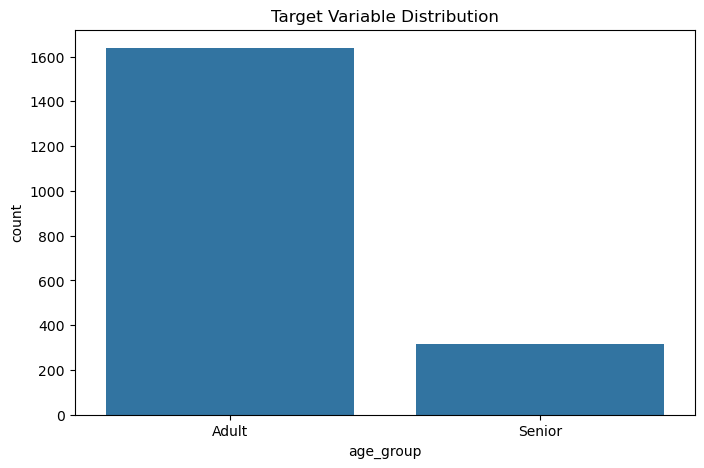


Class Ratios:
age_group
Adult     0.839139
Senior    0.160861
Name: proportion, dtype: float64


In [35]:
# Distribution of 'age_group' 
plt.figure(figsize=(8,5))
sns.countplot(data=train, x='age_group')
plt.title('Target Variable Distribution')
plt.show()

# Class ratios
class_ratio = train['age_group'].value_counts(normalize=True)
print(f"\nClass Ratios:\n{class_ratio}")

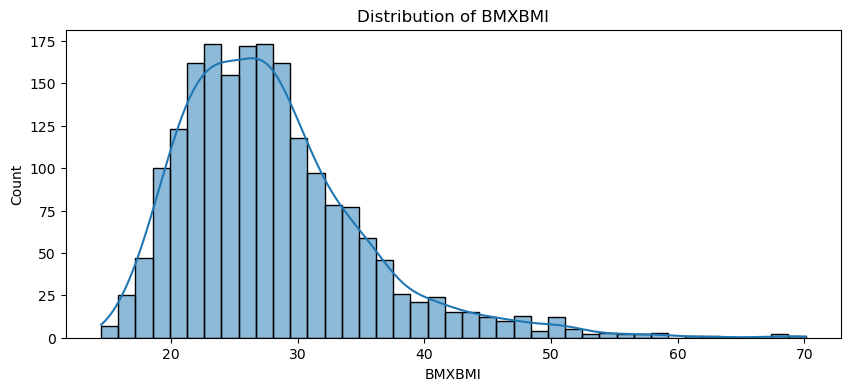

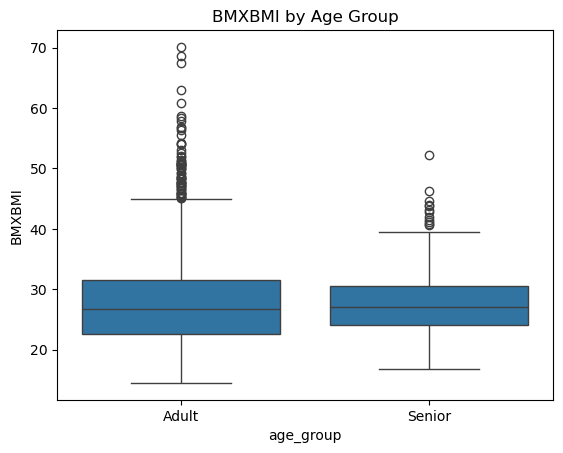

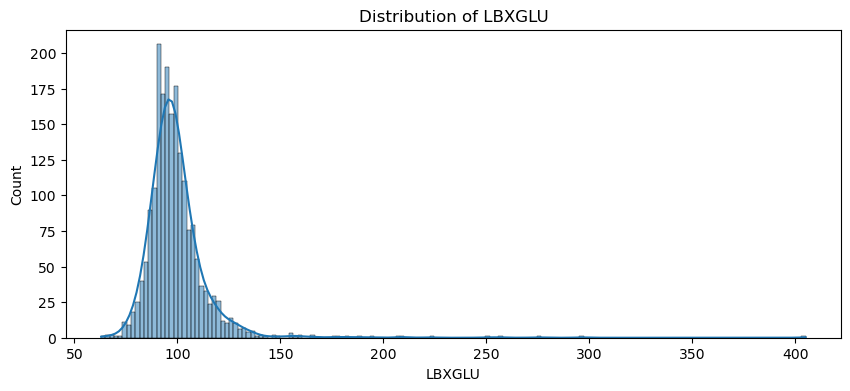

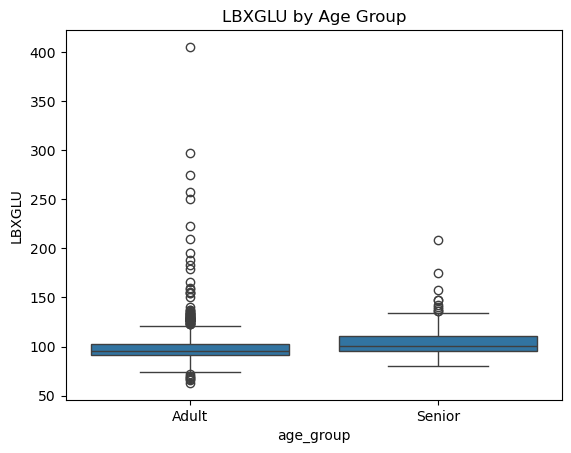

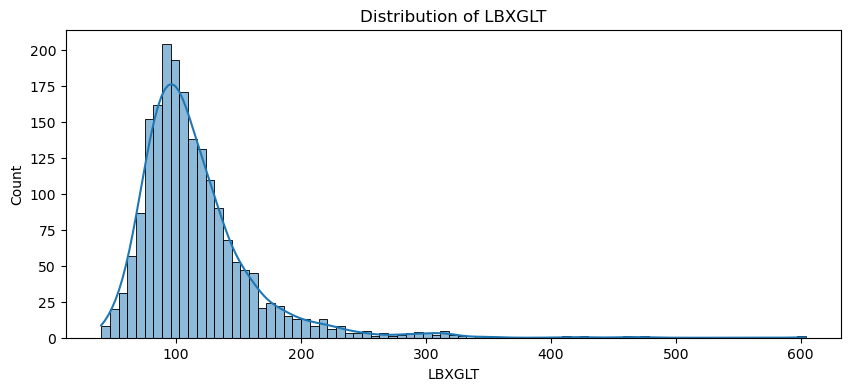

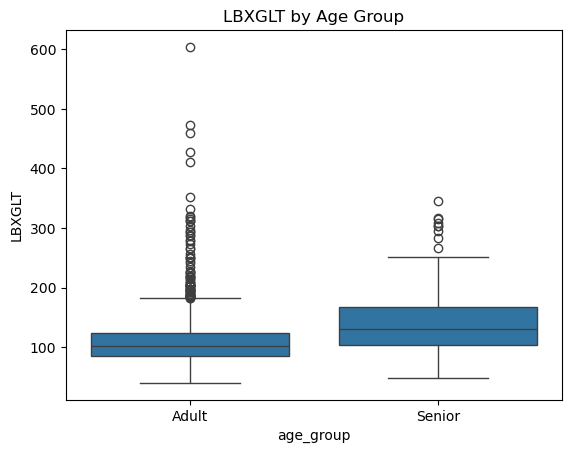

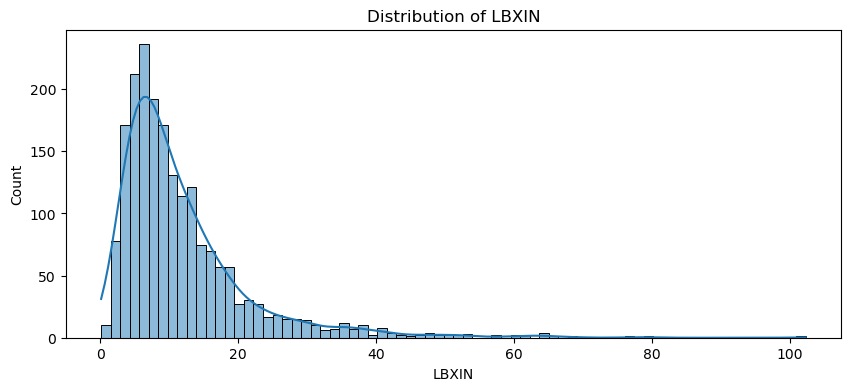

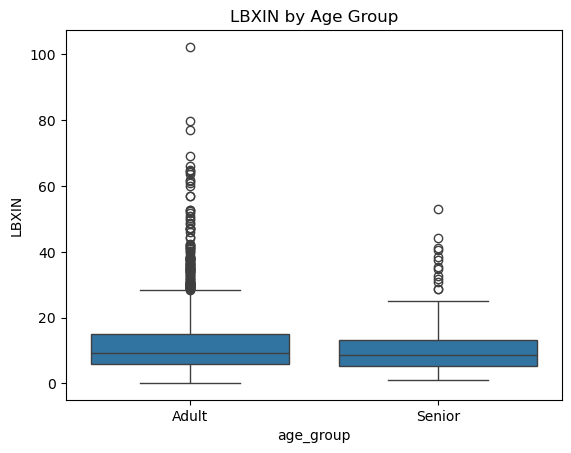

In [36]:
# Select numeric columns (excluding SEQN)
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']

# Distribution plots
for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    
    # Boxplot by age_group
    sns.boxplot(data=train, x='age_group', y=col)
    plt.title(f'{col} by Age Group')
    plt.show()

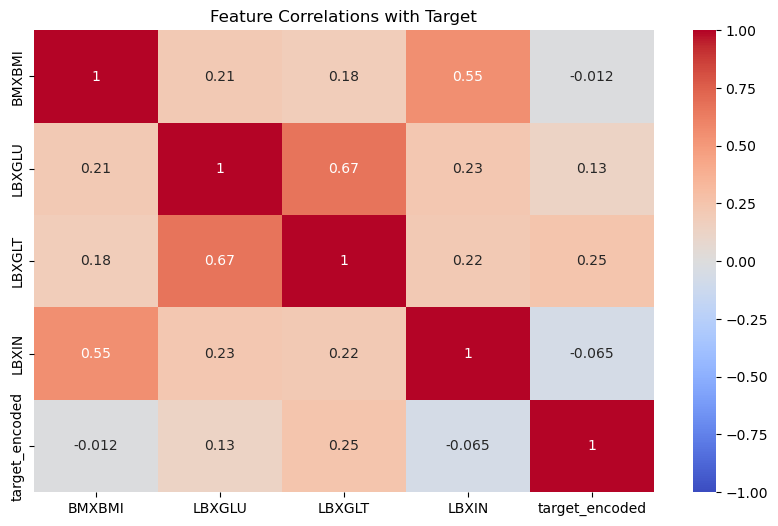

In [37]:
# Numeric features + target (encode target first)
train['target_encoded'] = train['age_group'].map({'Adult':0, 'Senior':1})

plt.figure(figsize=(10,6))
corr = train[num_cols + ['target_encoded']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlations with Target')
plt.show()

In [38]:
def handle_missing_safe(df):
    
    df = df.copy()
    
    # 1. Numerical columns - median imputation
    num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']  # Corrected column names
    for col in num_cols:
        if col in df.columns:
            median_val = df[col].median()
            df = df.assign(**{col: df[col].fillna(median_val)})
    
    # 2. Categorical columns - mode imputation
    cat_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']  # Corrected column names
    for col in cat_cols:
        if col in df.columns:
            mode_val = df[col].mode()[0]
            df = df.assign(**{col: df[col].fillna(mode_val)})
    
    # 3. ID column - forward fill (updated syntax)
    if 'SEQN' in df.columns:
        df = df.assign(SEQN=df['SEQN'].ffill())  # Replaced fillna(method='ffill')
    
    return df

# Apply to both datasets
train_clean = handle_missing_safe(train)
test_clean = handle_missing_safe(test)

In [39]:
#feature engineering
def add_features(df):
    df = df.copy()
    
    # BMI categorization
    if 'BMXBMI' in df.columns:
        df['BMI_Category'] = pd.cut(df['BMXBMI'],
            bins=[0, 18.5, 24.9, 29.9, 100],
            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        df['BMI_Category'] = df['BMI_Category'].astype(str)
    
    # Glucose to insulin ratio
    if 'LBXGLU' in df.columns and 'LBXIN' in df.columns:
        df['Glu_Insulin_Ratio'] = df['LBXGLU'] / (df['LBXIN'] + 1e-5)
    
    return df

train_fe = add_features(train_clean)
test_fe = add_features(test_clean)


In [40]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(train['age_group'])  # Adult=0, Senior=1

# Select features (excluding IDs and target)
X = train.drop(['SEQN', 'age_group'], axis=1)
X_test = test.drop('SEQN', axis=1)

# Ensure same columns in test set
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

In [41]:
#to validate
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

# Multiclass F1-optimized Random Forest
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=7,
    class_weight='balanced',  # Handles class imbalance
    min_samples_split=10,
    random_state=42,
    criterion='gini'         # Better for multiclass than 'entropy'
)

# Train
model.fit(X_train, y_train)

# Validate - Use average='weighted' for multiclass F1
val_preds = model.predict(X_val)
print(f"Weighted F1 Score: {f1_score(y_val, val_preds, average='weighted'):.4f}")

Weighted F1 Score: 0.9886


In [43]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# 1. Get class names and binarize validation labels
classes = np.unique(y_train)
y_val_bin = label_binarize(y_val, classes=classes)

# 2. Get predicted probabilities for each class
y_probs = model.predict_proba(X_val)

# 3. Find optimal threshold for each class
optimal_thresholds = {}
for i, class_name in enumerate(classes):
    precision, recall, thresholds = precision_recall_curve(y_val_bin[:, i], y_probs[:, i])
    
    # CORRECTED F1 calculation (was missing parentheses)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_thresholds[class_name] = thresholds[optimal_idx]
    print(f"Class {class_name} optimal threshold: {thresholds[optimal_idx]:.3f}")

# 4. Apply thresholds to test predictions
test_probs = model.predict_proba(X_test)
final_preds = np.array([
    np.argmax([(prob > optimal_thresholds[cls]) for cls in classes])
    for prob in test_probs
])

# 5. Create submission
submission = pd.DataFrame({
    'SEQN': test['SEQN'],
    'age_group': [classes[i] for i in final_preds]  # Map back to original labels
})

Class 0 optimal threshold: 0.671
Class 1 optimal threshold: 0.706
Class 2 optimal threshold: 0.335


In [44]:
# Verify your age groups 
print("Target classes and distribution:")
print(train['age_group'].value_counts())


Target classes and distribution:
age_group
Adult     1638
Senior     314
Name: count, dtype: int64


In [45]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Define numeric vs categorical columns (adjust based on your data)
numeric_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
categorical_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols)
    ],
    remainder='passthrough'
)

# Full pipeline with model
pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(class_weight='balanced', random_state=42)
)

# Train
pipeline.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['BMXBMI', 'LBXGLU', 'LBXGLT',
                                                   'LBXIN']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['RIAGENDR', 'PAQ605',
                                                   'DIQ010'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [46]:
# Apply missing value handling again (clean both datasets)
train_clean = handle_missing_safe(train)
test_clean = handle_missing_safe(test)

print("✅ Cleaned data ready: train_clean and test_clean")

✅ Cleaned data ready: train_clean and test_clean


In [47]:
# Import sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

# Define feature lists
num_features = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
cat_features = ['RIAGENDR', 'PAQ605', 'DIQ010']

print("✅ Features defined!")

✅ Features defined!


In [48]:
# Drop rows where target (age_group) is missing FIRST
train_clean = train_clean[train_clean['age_group'].notna()]

# Prepare X and y with clean data
X = train_clean[num_features + cat_features]
y = train_clean['age_group'].map({'Adult': 0, 'Senior': 1})  # Fixed dictionary syntax

# Split into train/validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Now safe because y has no NaN values
)

# Print shapes (corrected f-string syntax)
print(f"☐ X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}")

☐ X_train shape: (1561, 7), X_valid shape: (391, 7)


In [49]:
# Preprocessing (OneHotEncoder for categorical features)
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features)
    ],
    remainder='passthrough'
)

# Full pipeline with RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

print("✅ Pipeline created!")

✅ Pipeline created!


In [50]:
# Fit model
pipeline.fit(X_train, y_train)

print("✅ Model trained!")

✅ Model trained!


Submission1.csv saved!
